
# Global optimization of an MGA low-thrust trajectory
The example demonstrates the use of pykep/pygmo to perform global optimization of a multiple leg interplanetary trajectory over large launch windows. In particular, it defines a transfer between Earth and Mercury making use of a Venus intermediate fly-by as a global optimization problem (using the module trajopt udps) and it then attempts to find one solution using the Monotonic Basin Hopping meta-algorithm connected to an SQP local optimization technique.

This solution technique (MBH + SQP) was developed by members of the pykep team and the original publication can be found here:

Yam, C. H., D. D. Lorenzo, and D. Izzo. "Low-thrust trajectory design as a constrained global optimization problem." Proceedings of the Institution of Mechanical Engineers, Part G: Journal of Aerospace Engineering 225, no. 11 (2011): 1243-1251.

A., Cassioli, D. Izzo, Di Lorenzo, D., Locatelli, M. and Schoen, F.: "Global optimization approaches for optimal trajectory planning." In Modeling and optimization in space engineering, pp. 111-140. Springer, New York, NY, 2012.


In [1]:
# Imports
import pykep as pk
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import numpy as np
from pykep.examples import add_gradient

# Plotting imports
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'pygmo_plugins_nonfree'

In [2]:
# We define the optimization problem udp (User Defined Problem): an Earth-Venus-Mercury transfer with low-thrust
udp = pk.trajopt.mga_lt_nep(
     seq = [pk.planet.jpl_lp('earth'), pk.planet.jpl_lp('venus'), pk.planet.jpl_lp('mercury')],
     n_seg = [5, 20],
     t0 = [3000, 4000], # This is in mjd2000
     tof = [[100, 1000], [200, 2000]], # This is in days
     vinf_dep = 3., # This is in km/s
     vinf_arr = 2., # This is in km/s
     mass = [1000., 2000.0],
     Tmax = 0.5,
     Isp = 3500.0,
     fb_rel_vel = 6., # This is in km/s
     multi_objective = False,
     high_fidelity = False
)
prob = pg.problem(udp)
prob.c_tol = 1e-4
print(prob)

Problem name: <class 'pykep.trajopt._mga_lt_nep.mga_lt_nep'>
	C++ class name: pybind11::object

	Global dimension:			92
	Integer dimension:			0
	Fitness dimension:			44
	Number of objectives:			1
	Equality constraints dimension:		15
	Inequality constraints dimension:	28
	Tolerances on constraints: [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, ... ]
	Lower bounds: [3000, 100, 1000, -3000, -3000, ... ]
	Upper bounds: [4000, 1000, 2000, 3000, 3000, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



In [8]:
# We define the optimization algorithm uda (User Defined Algorithm). In this case we use SNOPT from the 
# module pgmo_plugins_nonfree. Note that we point to the snopt7_c library in our system. 
# In such a library is not available, nlopt sqlsqp can also be used here ....
uda = ppnf.snopt7(screen_output = False, library = "/usr/local/lib/libsnopt72_c.so", minor_version = 2) 
uda.set_integer_option("Major iterations limit", 1000)
uda.set_integer_option("Iterations limit", 200000)
uda.set_numeric_option("Major optimality tolerance", 1e-2)
uda.set_numeric_option("Major feasibility tolerance", 1e-8)
uda2 = pg.mbh(uda, 3, 0.05)
algo = pg.algorithm(uda2)
algo.set_verbosity(1)



In [9]:
# We create a population of 100 random initial guesses
pop = pg.population(prob, 100)
# And optimize
pop = algo.evolve(pop)


In [15]:
print("Is feasible: ", prob.feasibility_f(pop.champion_f))
print("Final Mass at Mercury: ", -pop.champion_f[0], "Kg")

Is feasible:  True
Final Mass at Mercury:  1227.9619205547747 Kg


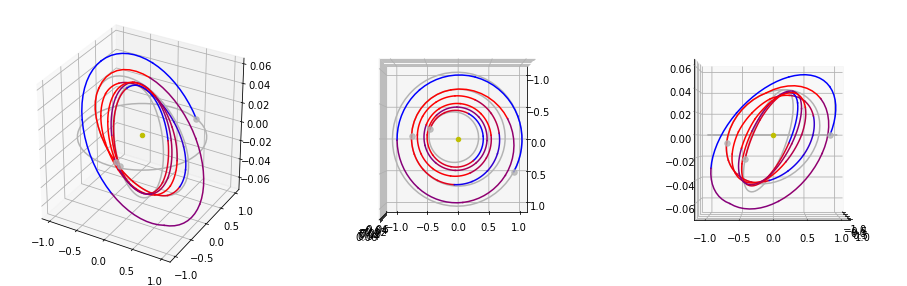

In [14]:
# We plot 
mpl.rcParams['legend.fontsize'] = 10

# Create the figure and axis
fig = plt.figure(figsize = (16,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
udp.plot(pop.champion_x, axes = ax1)

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.view_init(90, 0)
udp.plot(pop.champion_x, axes = ax2)

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.view_init(0,0)
udp.plot(pop.champion_x, axes = ax3)


